# Data Breach Analytics 2005 - 2017 (Part III Unsupervised Machine Learning)
#### by Miriam Rodriguez 

In [1]:
import warnings
warnings.filterwarnings(action= 'ignore')  # To ignore all warnings that arise here to enhance clarity

In [2]:
# import packages

#import nltk (natural language tool kit), a popular python package for text mining
import nltk
# stopwords, FreqDist, word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

#regular expression
import re
#csv
import csv
# Excel-like format
import pandas as pd
#data visualization
import matplotlib.pyplot as plt
% matplotlib inline

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import numpy
import pyLDAvis.gensim

In [3]:
#import breach data ... open or read the breach data
df = pd.read_csv("databreach_cleaned.csv")
df.head(2)

Breach_Year                        Company          State Breach_Type  \
0         2006      Deloitte & Touche, McAfee  United States        PORT   
1         2007  TennCare, Americhoice Inc.     United States        PORT   

  Organization_Type  Total_Recs  \
0               BSO        9290   
1               MED       67000   

                                         Description   Latitude  Longitude  \
0  An external auditor lost a CD with names, Soci...  37.090240 -95.712891   
1  There are 67,000 TennCare \r\n            enro...  35.960638 -83.920739   

   Breach_Type_CAT  Organization_Type_CAT  State_CAT  Year_CAT       GDP  
0                5                      2          0         2  72466970  
1                5                      6          0         3  75725457

In [4]:
df_incident = df[["Description"]]
df_incident

Description
0     An external auditor lost a CD with names, Soci...
1     There are 67,000 TennCare \r\n            enro...
2        A laptop computer was stolen from a vehicle.  
3     A Fidelity laptop used by a former Fidelity em...
4     A former contract worker of a Japanese commerc...
5     Patient names, addresses, Social Security numb...
6     At least 18 colleges are scrambling to inform ...
7     Hundreds of files - with Social Security numbe...
8     A computer was compromised by a virus. That ca...
9     \N\r\nLocation of breached information: Other\...
10    On November 5, 2010, the Puerto Rico Departmen...
11    Triple-S Management Corporation (“TRIPLE-S”), ...
12    The covered entity (CE), Hospital Auxilio Mutu...
13    After a falling out among members of Perverted...
14    Three companies who resell consumer credit rep...
15    The February 1 theft of a contractor's laptop ...
16    A portable electronic device was discovered st...
17    A woman who worked at Regions is accused of cr...
18    A state-owned laptop was stolen from the home ...
19    A courier was attacked on May 9.  The attacker...
20    Subscribers to the ISP news and review site DS...
21    Factions of Anonymous and Antisec posted sensi...
22    An anonymous tipster alerted reporters to a br...
23    A former employee hacked into APA's database, ...
24    A computer or laptop was discovered to have be...
25    State employees who canceled their health or d...
26    The July 25 theft of a laptop resulted in the ...
27    The car theft of backup tapes resulted in the ...
28    \N\r\nLocation of breached information: Deskto...
29    HIPAA settlement demonstrates importance of im...
...                                                 ...
8147  "Wauwatosa, Wis.-based Metropolitan Urology Gr...
8148  Location of breached information: Email\r\nBus...
8149  Location of breached information: Email\r\nBus...
8150  Location of breached information: Email\r\nBus...
8151  Location of breached information: Email\r\nBus...
8152  Location of breached information: Email\r\nBus...
8153  Location of breached information: Paper/Films\...
8154  Location of breached information: Desktop Comp...
8155  "The Medical College of Wisconsin has notified...
8156  "What happened?We have extensive measures in p...
8157  Location of breached information: Email\r\nBus...
8158  Location of breached information: Electronic M...
8159  Location of breached information: Electronic M...
8160  The Doral Corporation experienced a phishing a...
8161  Location of breached information: Laptop\r\nBu...
8162  Location of breached information: Email\r\nBus...
8163  Location of breached information: Network Serv...
8164  A customer of the Rocky Mountain \r\n         ...
8165  The personal information of about 9,000 childr...
8166  Applicants of the Wyoming Kid Care CHIP progra...
8167  On February 23, 2011, The Community Action Par...
8168  The covered entity (CE), Community Action Part...
8169  Location of breached information: Desktop Comp...
8170  The covered entity (CE), Wyoming Department of...
8171  The covered entity (CE), North Big Horn Hospit...
8172  As reported by Health and Human Services hacki...
8173  Location of breached information: Email\r\nBus...
8174  "What HappenedOn February 9, 2017, we learned ...
8175  Location of breached information: Paper/Films\...
8176  Location of breached information: Paper/Films\...

[8177 rows x 1 columns]

In [5]:
# text preprocessing for incident descriptions
# currently the data are in list ... convert to string
tokens = str(df_incident)
#lowercases
tokens = tokens.lower()
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)

#tokenization or word split
tokens = word_tokenize(tokens)

#get stemming words or lemmas
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)

#Remove stopwords
tokens = (word for word in tokens if word not in stopwords.words('english'))

more_stopwords = set(('location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see'))

extra_stoplist = set(stopwords.words('english')) | more_stopwords

tokens = (word for word in tokens if word not in extra_stoplist)

# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())

#remove short words
tokens = (word for word in tokens if len(word) >= 3)



In [6]:
# Word frequency analysis for breach descriptions
#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(tokens)
fdist

FreqDist({'information': 20, 'breached': 19, 'nbus': 8, 'email': 8, 'laptop': 7, 'entity': 4, 'paper': 3, 'theft': 3, 'february': 3, 'computer': 3, ...})

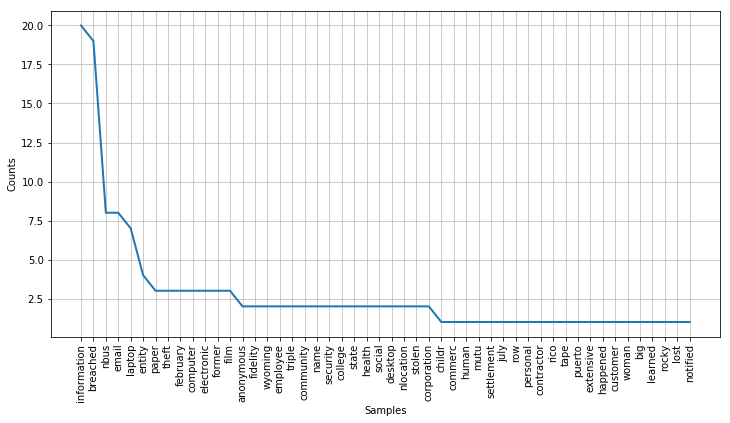

In [7]:
plt.figure(figsize=(12,6))
fdist.plot(50)

## Popular words from the breach dataset

In [8]:
# Most popular words for breaches
fdist.most_common(50)



[('information', 20),
 ('breached', 19),
 ('nbus', 8),
 ('email', 8),
 ('laptop', 7),
 ('entity', 4),
 ('paper', 3),
 ('theft', 3),
 ('february', 3),
 ('computer', 3),
 ('electronic', 3),
 ('former', 3),
 (u'film', 3),
 ('anonymous', 2),
 ('fidelity', 2),
 ('wyoming', 2),
 ('employee', 2),
 ('triple', 2),
 ('community', 2),
 (u'name', 2),
 ('security', 2),
 (u'college', 2),
 ('state', 2),
 ('health', 2),
 ('social', 2),
 ('desktop', 2),
 ('nlocation', 2),
 ('stolen', 2),
 ('corporation', 2),
 ('childr', 1),
 ('commerc', 1),
 ('human', 1),
 ('mutu', 1),
 ('settlement', 1),
 ('july', 1),
 (u'row', 1),
 ('personal', 1),
 ('contractor', 1),
 ('rico', 1),
 (u'tape', 1),
 ('puerto', 1),
 ('extensive', 1),
 ('happened', 1),
 ('customer', 1),
 ('woman', 1),
 ('big', 1),
 ('learned', 1),
 ('rocky', 1),
 ('lost', 1),
 ('notified', 1)]

The most popular words for breach descriptions relate to theft of electronic data or stolen data, employees such as former and contractors in corporations.

In [9]:
# Word frequency analysis using bi-grams
# what if you have additional stopwords to be removed
tokens = str(df_incident)
#lowecases
tokens = tokens.lower()
# Remove useless numbers and alphanumerical words
tokens = re.sub("[^a-zA-Z0-9]", " ", tokens)
#tokenization or word split
tokens = word_tokenize(tokens)
#get stemming words or lemmas
wordnet_lemmatizer = WordNetLemmatizer()
tokens = (wordnet_lemmatizer.lemmatize(word) for word in tokens)

tokens = (word for word in tokens if word not in stopwords.words('english'))

#additional stopwords
more_stopwords = set(('location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see'))

extra_stoplist = set(stopwords.words('english')) | more_stopwords

# Filter non-alphanumeric characters from tokens
tokens = (word for word in tokens if word.isalpha())
#remove short words
tokens = (word for word in tokens if len(word) >= 3)
#Create your bigrams ... a bigram are a pair of two tokens
bigrams = nltk.bigrams(tokens)
#compute frequency distribution for all the bigrams in the text
fdist_bi = nltk.FreqDist(bigrams)
fdist_bi



FreqDist({('breached', 'information'): 19, ('location', 'breached'): 17, ('information', 'email'): 8, ('email', 'nbus'): 8, ('nbus', 'location'): 7, ('covered', 'entity'): 4, ('information', 'paper'): 3, ('paper', u'film'): 3, ('social', 'security'): 2, (u'film', 'location'): 2, ...})

## Popular bi-grams 

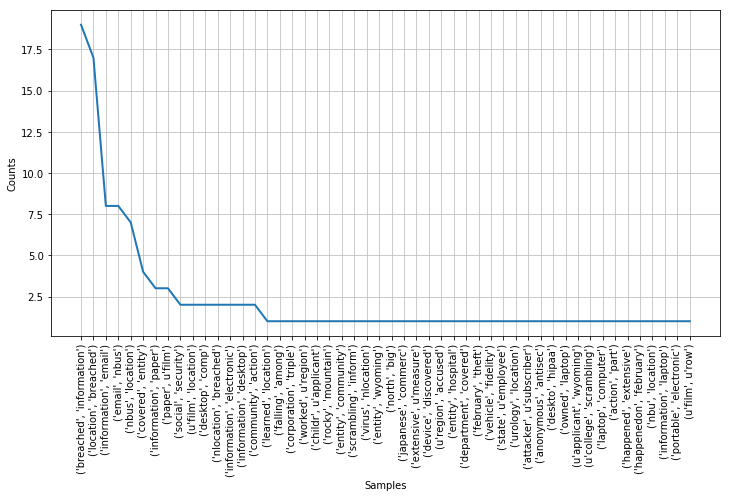

In [10]:
# plot word frequency using bigram
plt.figure(figsize=(12,6))
fdist_bi.plot(50)

In [11]:
# Most popular words 
fdist_bi.most_common(50)

[(('breached', 'information'), 19),
 (('location', 'breached'), 17),
 (('information', 'email'), 8),
 (('email', 'nbus'), 8),
 (('nbus', 'location'), 7),
 (('covered', 'entity'), 4),
 (('information', 'paper'), 3),
 (('paper', u'film'), 3),
 (('social', 'security'), 2),
 ((u'film', 'location'), 2),
 (('desktop', 'comp'), 2),
 (('nlocation', 'breached'), 2),
 (('information', 'electronic'), 2),
 (('information', 'desktop'), 2),
 (('community', 'action'), 2),
 (('learned', 'location'), 1),
 (('falling', 'among'), 1),
 (('corporation', 'triple'), 1),
 (('worked', u'region'), 1),
 (('childr', u'applicant'), 1),
 (('rocky', 'mountain'), 1),
 (('entity', 'community'), 1),
 (('scrambling', 'inform'), 1),
 (('virus', 'nlocation'), 1),
 (('entity', 'wyoming'), 1),
 (('north', 'big'), 1),
 (('japanese', 'commerc'), 1),
 (('extensive', u'measure'), 1),
 (('device', 'discovered'), 1),
 ((u'region', 'accused'), 1),
 (('entity', 'hospital'), 1),
 (('department', 'covered'), 1),
 (('february', 'theft

In [12]:
df_incident.to_csv('databreach.txt', index=False, sep=' ', header=None)

In [13]:
df_incident.to_csv('databreach.csv', index=False, header=None)

## Word cloud using a mask image. 

(-0.5, 399.5, 199.5, -0.5)

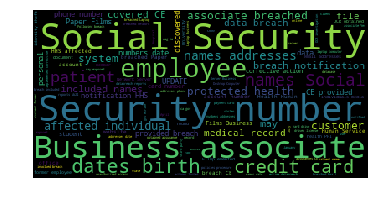

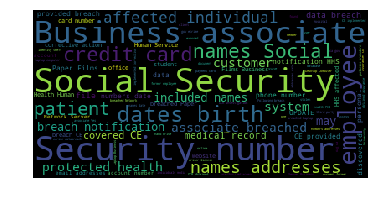

In [14]:
# word cloud 
from os import path
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

# Read the whole text.
text = open(path.join('databreach.txt')).read()

#additional stopwords
stopwords = set(STOPWORDS)
stopwords.add("report")
stopwords.add("company")
stopwords.add("ago")
stopwords.add("said")
stopwords.add("hours")
stopwords.add("will")
stopwords.add("well")
stopwords.add("year")
stopwords.add("abuse")
stopwords.add("also")
stopwords.add("pm")
stopwords.add("now")
stopwords.add("information")
stopwords.add("happened")
stopwords.add("home")
stopwords.add("hour")
stopwords.add("entity")
stopwords.add("big")
stopwords.add("used")
stopwords.add("name")
stopwords.add("par")
stopwords.add("else")
stopwords.add("simply")
stopwords.add("new")
stopwords.add("yesterday")
stopwords.add("getting")
stopwords.add("vehicle")
stopwords.add("location")
stopwords.add("present")
stopwords.add("film")
stopwords.add("row")

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud)
plt.axis("off")

# take relative word frequencies into account, lower max_font_size
wordcloud = WordCloud(max_font_size=40, relative_scaling=.5, stopwords=stopwords).generate(text)
plt.figure()
plt.imshow(wordcloud)
plt.axis("off")


## The themes here appear to be social security number, credit cards, birthdates, names and addressess, employees and business associates.

In [15]:
#import breach data ... open or read the breach data
from nltk.corpus import stopwords
texts = []
r = csv.reader(open('databreach.csv', 'rb'))
for i in r:
    texts.append(i)  
len(texts)

8177

In [16]:
# Remove useless numbers and alphanumerical words
documents = [re.sub("[^a-zA-Z]+", " ", str(text)) for text in texts]

# tokenize
texts = [[word for word in text.lower().split() ] for text in documents]

# stemming words: having --> have; friends --> friend
lmtzr = WordNetLemmatizer()
texts = [[lmtzr.lemmatize(word) for word in text ] for text in texts]

porter_stemmer = PorterStemmer()
texts = [[porter_stemmer.stem(word) for word in text ] for text in texts]

# remove common words 
stoplist = stopwords.words('english')
texts = [[word for word in text if word not in stoplist] for text in texts]

#remove short words
texts = [[ word for word in tokens if len(word) >= 3 ] for tokens in texts]


In [17]:
# A list of extra stopwords 
extra_stopwords = ['location', 'three', 'member', 'covered', 'discovered', 'soci', 'based', 'resulted', 'comp', 'perverted',
                'action', 'doral', 'childre', 'ago', 'hour', 'year', 'abuse', 'also', 'pm', 'now', 'columns', 'else',
                'simply', 'new', 'yesterday', 'getting', 'will', 'people', 'need', 'think', 'well','going', 'can', 'country', 
                'know', 'lot', 'get','make','way','want', 'like','say','got','said','just','something','tell','put','now',
                'bad','back','want','right','every','one','use','come','never', 'many','along','things','day','also','first',
                'guy', 'great', 'take', 'good', 'much','anderson', 'let', 'would', 'year', 'thing', 'america',
                'talk', 'talking', 'thank', 'does', 'give', 'look', 'believe', 'tonight','today','see']
extra_stoplist = extra_stopwords
texts = [[word for word in text if word not in extra_stoplist] for text in texts]


In [18]:
# this is text processing required for topic modeling with Gensim

## Create a dictionary representation of the documents.
dictionary = Dictionary(texts)
dictionary.save('databreach.dict')  # store the dictionary, for future reference

len(dictionary)

10712

In [19]:
## Remove rare and common tokens.
# ignore words that appear in less than 2 documents or more than 40% documents (remove too frequent & infrequent words) - an optional step
dictionary.filter_extremes(no_below=2, no_above=0.4) 
len(dictionary)

5083

In [20]:
# convert words to vectors or integers, this is text processing required for topic modeling with Gensim
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('databreach.mm', corpus)  # store to disk, for later use  # store to disk, for later use
len(corpus)

8177

In [21]:
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens: 5083
Number of documents: 8177


In [22]:
# Save the dict and corpus for later retrievalsaved dict

saved_dict = dictionary.load('databreach.dict')

for i in saved_dict.token2id.iteritems():
    print i

(u'nalleg', 8649)
(u'yellow', 6690)
(u'interchang', 9805)
(u'four', 103)
(u'payoff', 10201)
(u'accret', 543)
(u'lori', 582)
(u'ntulsa', 5231)
(u'hermann', 10076)
(u'lord', 8389)
(u'ncqa', 7135)
(u'digit', 496)
(u'deli', 981)
(u'fradul', 3825)
(u'wjb', 5178)
(u'dell', 8960)
(u'formspr', 3090)
(u'honeywel', 8245)
(u'delt', 8682)
(u'delv', 9376)
(u'oceana', 10643)
(u'broward', 5826)
(u'viewabl', 1577)
(u'kasperski', 7502)
(u'disturb', 8901)
(u'prize', 4134)
(u'cashout', 6287)
(u'carthag', 7977)
(u'voyeur', 9225)
(u'wednesday', 1801)
(u'assail', 7732)
(u'inur', 4164)
(u'bcbsnc', 9140)
(u'terabyt', 4899)
(u'unathor', 10560)
(u'onehitplay', 2970)
(u'charter', 7856)
(u'kuroi', 7414)
(u'miller', 3132)
(u'seper', 8307)
(u'frederick', 7383)
(u'budget', 5471)
(u'second', 668)
(u'nget', 8779)
(u'nsuggest', 1936)
(u'melvin', 9967)
(u'maloney', 7567)
(u'decre', 8506)
(u'launchpoint', 7052)
(u'clorox', 7924)
(u'ongo', 1450)
(u'widget', 4188)
(u'intellectu', 3271)
(u'avert', 8736)
(u'cenabl', 10241)
(

(u'pbh', 9107)
(u'enterpris', 2761)
(u'quicker', 4535)
(u'tonja', 1433)
(u'cunauthor', 4036)
(u'paso', 5233)
(u'sync', 3440)
(u'past', 1097)
(u'rxamerica', 9771)
(u'pass', 4579)
(u'hicn', 6195)
(u'voluntari', 2588)
(u'deleg', 6599)
(u'villanova', 9453)
(u'npeopl', 8907)
(u'richard', 3891)
(u'clock', 4880)
(u'section', 1998)
(u'rackspac', 5455)
(u'delet', 495)
(u'digist', 4286)
(u'genesco', 9764)
(u'mtso', 9232)
(u'method', 1722)
(u'contrast', 4727)
(u'full', 937)
(u'hash', 761)
(u'sarasota', 5832)
(u'situat', 1951)
(u'misspel', 4781)
(u'homelink', 7078)
(u'hast', 2908)
(u'nrecov', 8140)
(u'legend', 3328)
(u'vumc', 9818)
(u'osco', 6619)
(u'sender', 4497)
(u'cbecaus', 4787)
(u'brutal', 7912)
(u'prior', 717)
(u'anheus', 7972)
(u'therapeut', 2904)
(u'pick', 1712)
(u'introductori', 6684)
(u'vic', 4119)
(u'via', 400)
(u'depart', 165)
(u'vin', 5533)
(u'unredact', 10334)
(u'esrb', 8580)
(u'apha', 5557)
(u'ngroup', 8739)
(u'select', 946)
(u'kaweah', 2681)
(u'handset', 3701)
(u'sitter', 5433)
(u

(u'nsome', 6208)
(u'marketplac', 3135)
(u'paul', 2632)
(u'brokerag', 1463)
(u'broomfield', 7772)
(u'demograph', 1325)
(u'web', 491)
(u'wed', 3733)
(u'wei', 1003)
(u'greensburg', 9466)
(u'arrest', 423)
(u'gyft', 4122)
(u'exempt', 6697)
(u'urochart', 8290)
(u'compet', 6177)
(u'government', 6348)
(u'webpag', 3630)
(u'chancellor', 1864)
(u'spokespeopl', 2804)
(u'piec', 81)
(u'crux', 8398)
(u'cruz', 2507)
(u'five', 498)
(u'nplaintiff', 8782)
(u'desk', 2557)
(u'joliet', 6767)
(u'nvm', 9757)
(u'password', 105)
(u'pier', 10163)
(u'recurr', 3436)
(u'uploadedfil', 8845)
(u'resid', 58)
(u'microblog', 8943)
(u'canyon', 9876)
(u'mha', 9302)
(u'stagger', 6302)
(u'crisi', 2456)
(u'dynegi', 8255)
(u'npoint', 10441)
(u'incent', 5486)
(u'silverscript', 1878)
(u'captur', 2329)
(u'clientel', 5133)
(u'nsuffer', 8908)
(u'thief', 530)
(u'nconcern', 7396)
(u'guaranti', 8603)
(u'thier', 7027)
(u'ballot', 2298)
(u'transport', 1372)
(u'feder', 570)
(u'hoarder', 9701)
(u'avoid', 552)
(u'managedm', 3629)
(u'hackap

(u'shopnat', 9157)
(u'postcard', 3535)
(u'connectingthread', 9260)
(u'pharmaceut', 1460)
(u'ucd', 2646)
(u'ehealth', 4539)
(u'cascad', 9390)
(u'cisco', 4357)
(u'verbal', 5542)
(u'nlaw', 3420)
(u'notifica', 4183)
(u'reutrn', 6812)
(u'hrconnect', 7550)
(u'anomal', 8406)
(u'glenwood', 6604)
(u'ceae', 3928)
(u'kaiser', 976)
(u'uhealth', 6122)
(u'maersk', 8475)
(u'dealership', 2827)
(u'nproduc', 10204)
(u'withouth', 973)
(u'cnobodi', 4808)
(u'cconsent', 6182)
(u'epson', 3051)
(u'compris', 4750)
(u'osha', 7846)
(u'asap', 4683)
(u'sixti', 1000)
(u'sixth', 6339)
(u'nbirmingham', 5221)
(u'volkswagen', 3920)
(u'nmg', 10181)
(u'servalt', 10536)
(u'nmb', 10239)
(u'throw', 8505)
(u'brighton', 7599)
(u'sra', 10363)
(u'central', 1309)
(u'srg', 4706)
(u'testimoni', 1146)
(u'sri', 10423)
(u'srp', 3990)
(u'gump', 10155)
(u'wolf', 7203)
(u'truncat', 3048)
(u'underway', 7400)
(u'backup', 618)
(u'processor', 986)
(u'unsalt', 4173)
(u'outlook', 1565)
(u'elementari', 3130)
(u'copier', 8565)
(u'indot', 6922)


(u'bee', 4985)
(u'anaheim', 3276)
(u'bep', 5522)
(u'bev', 5711)
(u'exhibit', 7612)
(u'deliveri', 2326)
(u'ventiv', 6567)
(u'barg', 4588)
(u'journey', 5142)
(u'congression', 5473)
(u'ventil', 9977)
(u'border', 2305)
(u'iduskcn', 10080)
(u'screw', 4460)
(u'bladen', 9068)
(u'selco', 7480)
(u'naccident', 8350)
(u'mailaccount', 5807)
(u'reservist', 6321)
(u'unawar', 2020)
(u'bourna', 2929)
(u'tactic', 1362)
(u'detector', 5980)
(u'brand', 1674)
(u'singl', 3835)
(u'deploy', 699)
(u'galleri', 9032)
(u'discov', 136)
(u'rego', 6560)
(u'unannounc', 5328)
(u'montana', 2858)
(u'stereo', 671)
(u'urg', 3732)
(u'url', 4797)
(u'urm', 10518)
(u'upset', 1749)
(u'fafsa', 5790)
(u'issuanc', 4858)
(u'inde', 9444)
(u'certifikid', 5709)
(u'snapshot', 4962)
(u'bhcare', 5364)
(u'businessman', 9745)
(u'indi', 7051)
(u'affair', 2380)
(u'parker', 9320)
(u'parkev', 2230)
(u'schein', 6662)
(u'anyway', 4587)
(u'sheriff', 2642)
(u'ngo', 3418)
(u'forev', 4908)
(u'manufactur', 3983)
(u'hacktivist', 2849)
(u'glyton', 502

(u'ulm', 7264)
(u'fla', 5214)
(u'claim', 493)
(u'clain', 8323)
(u'plaza', 2477)
(u'mongo', 6539)
(u'predict', 6464)
(u'cepiq', 9619)
(u'agent', 1384)
(u'drawer', 3520)
(u'crazi', 7193)
(u'tabl', 7140)
(u'council', 2170)
(u'agenc', 470)
(u'clair', 6756)
(u'palli', 9938)
(u'purs', 2232)
(u'nmsu', 8399)
(u'tilt', 9982)
(u'nyp', 8576)
(u'penthous', 4375)
(u'nyu', 8453)
(u'sunday', 2516)
(u'purg', 1962)
(u'pure', 8158)
(u'nyc', 8592)
(u'sworn', 5018)
(u'pathway', 1544)
(u'lovens', 959)
(u'map', 8031)
(u'mar', 2515)
(u'wftv', 6163)
(u'intrud', 1862)
(u'evildo', 1012)
(u'may', 411)
(u'max', 6745)
(u'comerica', 6377)
(u'umain', 7303)
(u'brookdal', 8703)
(u'intrus', 908)
(u'membership', 484)
(u'mad', 7829)
(u'snp', 10278)
(u'udpat', 5494)
(u'mah', 6991)
(u'underscor', 6566)
(u'grow', 3401)
(u'accessori', 10584)
(u'thorni', 677)
(u'neck', 8572)
(u'johnson', 8132)
(u'talx', 4744)
(u'neca', 7364)
(u'gestat', 6087)
(u'switch', 2418)
(u'franciscowashington', 8815)
(u'jail', 2414)
(u'deposit', 427)
(

(u'poolsupplyunlimit', 4531)
(u'perimet', 8569)
(u'delawar', 5452)
(u'nhave', 3683)
(u'trustedid', 9789)
(u'bodi', 3174)
(u'cours', 2035)
(u'bachelor', 9251)
(u'intercept', 2227)
(u'tenur', 4397)
(u'administaff', 9846)
(u'sinc', 800)
(u'jointli', 3769)
(u'talent', 833)
(u'weinstein', 2751)
(u'conceiv', 7820)
(u'alaska', 1006)
(u'cert', 9936)
(u'earli', 922)
(u'implement', 175)
(u'nlower', 7903)
(u'honor', 2791)
(u'binghamton', 8433)
(u'southlak', 10246)
(u'blizzard', 3207)
(u'talari', 1490)
(u'costli', 7842)
(u'zocdoc', 8874)
(u'minnesota', 587)
(u'cspoof', 10467)
(u'presidenti', 5731)
(u'limo', 5891)
(u'tap', 1200)
(u'gateway', 7425)
(u'lime', 3807)
(u'chf', 7206)
(u'chi', 8441)
(u'chj', 4950)
(u'nobel', 10565)
(u'websit', 384)
(u'esecurityplanet', 4514)
(u'advoc', 6714)
(u'butler', 7010)
(u'irandef', 9985)
(u'webcrawl', 7009)
(u'steakhous', 3957)
(u'dentistri', 2766)
(u'kiosk', 3086)
(u'cyberattac', 8060)
(u'astoria', 9510)
(u'trail', 6036)
(u'train', 327)
(u'cstar', 7307)
(u'nypd', 

(u'pdfupdat', 6603)
(u'counsel', 1454)
(u'paitient', 8680)
(u'multifactor', 10425)
(u'bailment', 8606)
(u'nrate', 4005)
(u'franciscan', 7002)
(u'fairbank', 1607)
(u'latch', 8619)
(u'lsat', 9978)
(u'penal', 7959)
(u'nno', 6804)
(u'trio', 8097)
(u'estonia', 6288)
(u'decrypt', 1347)
(u'rahm', 2746)
(u'expedia', 6902)
(u'desir', 5436)
(u'kloraneusa', 5022)
(u'check', 132)
(u'assembl', 2286)
(u'pipe', 7704)
(u'ticor', 6137)
(u'tip', 3757)
(u'tim', 3522)
(u'tin', 7407)
(u'prattvil', 1597)
(u'implant', 2489)
(u'depot', 5961)
(u'clubhous', 6582)
(u'freelanc', 8773)
(u'evergreen', 10490)
(u'toan', 4941)
(u'solano', 3298)
(u'brandman', 2784)
(u'phoenix', 1736)
(u'genentech', 2883)
(u'twain', 8177)
(u'consid', 2102)
(u'sql', 467)
(u'sjsu', 3050)
(u'ebpma', 3898)
(u'identityforc', 4480)
(u'longev', 4252)
(u'undisclos', 1058)
(u'unbeknownst', 6852)
(u'apparatu', 7217)
(u'yacht', 3713)
(u'cyear', 4499)
(u'withhold', 4146)
(u'vietnam', 3430)
(u'paychoic', 8251)
(u'decommiss', 44)
(u'coach', 9240)
(u'

(u'electrolog', 3392)
(u'rig', 7251)
(u'illinoi', 790)
(u'picturefram', 9159)
(u'eyewear', 4050)
(u'lengthi', 6086)
(u'behav', 8286)
(u'ntwo', 7524)
(u'cdark', 979)
(u'flown', 9411)
(u'cryptocurr', 5011)
(u'lower', 792)
(u'machineri', 2786)
(u'searchabl', 3046)
(u'inusr', 9438)
(u'disburs', 4476)
(u'cheer', 1828)
(u'nvestig', 7142)
(u'lowel', 7574)
(u'propos', 2468)
(u'reliant', 10145)
(u'nbitcoin', 5623)
(u'maschino', 9363)
(u'vigilant', 10209)
(u'regardless', 9248)
(u'northern', 2525)
(u'continent', 1890)
(u'kirkbrid', 9591)
(u'involvedwhil', 10261)
(u'tablet', 2750)
(u'contractor', 404)
(u'callsend', 1494)
(u'finder', 6156)
(u'passcod', 7416)
(u'complaint', 1282)
(u'vendor', 113)
(u'npaper', 1943)
(u'niosh', 6519)
(u'davelewi', 3675)
(u'karmano', 7784)
(u'wslcb', 10625)
(u'siteman', 8099)
(u'comsi', 9784)
(u'confront', 5263)
(u'eastsid', 6410)
(u'earthquak', 3670)
(u'sunbridg', 8402)
(u'collect', 230)
(u'yorker', 6636)
(u'godiva', 8684)
(u'hallmark', 9329)
(u'donnelley', 6783)
(u'ne

In [23]:
# save the corpus

corpus_saved = corpora.MmCorpus('databreach.mm')

## Optimal k value - Also used in Classification Models


In [25]:
numpy.random.seed(1) # setting random seed to get the same results each time. 
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=35, passes=50)

In [26]:
model.save('lda.model') # same for tfidf, lda, ...
#model = models.LdaModel.load('data/lda.model')

## Prints the topics (Term-Topic Distribution)

In [27]:
# print words without probability
for i in range(0,35):
    topics = model.show_topic(i, 10)
    print ', '.join([str(word[0]) for word in topics])

report, servic, health, human, gov, ocr, specif, ocrport, jsf, jsessionid
mail, sent, address, letter, social, receiv, error, vendor, print, contain
access, author, employe, without, awar, becam, fire, hospit, investig, abl
hacker, address, access, email, password, databas, onlin, websit, hack, post
card, credit, custom, payment, debit, affect, system, store, may, expir
employe, ident, theft, charg, fraudul, fraud, arrest, former, dishonest, two
investig, may, report, unauthor, access, http, includ, thi, gov, parti
data, com, http, www, includ, state, person, news, notifi, compani
result, exposur, theft, blue, safe, occur, shield, agent, decemb, massachusett
technolog, comput, attorney, gener, softwar, record, system, offic, letter, group
state, polic, depart, washington, district, offic, agenc, boe, chief, public
document, record, found, applic, social, file, box, dumpster, contain, shred
custom, account, loan, compani, credit, bank, union, skype, servic, call
individu, ocr, phi, prov

## Assign the topics to the documents in corpus (Document-Topic Distribution)


In [28]:
lda_corpus = model[corpus]

results = []
for i in lda_corpus:
#    print i
    results.append(i)
print 

In [29]:
# finding highest value from each row
toptopic = [max(collection, key=lambda x: x[1])[0] for collection in results]
# toptopic

In [30]:
toptopic = pd.DataFrame(toptopic)
documents = pd.DataFrame(documents)
documents = documents.rename(columns = {0: 'documents'})
summary = documents.join(toptopic)
summary.head(10)

documents   0
0   An external auditor lost a CD with names Soci...  31
1   There are TennCare r r n enrollees at risk of...  18
2   A laptop computer was stolen from a vehicle x...  16
3   A Fidelity laptop used by a former Fidelity e...  31
4   A former contract worker of a Japanese commer...  32
5   Patient names addresses Social Security numbe...  19
6   At least colleges are scrambling to inform te...  16
7   Hundreds of files with Social Security number...  11
8   A computer was compromised by a virus That ca...  30
9   N r r nLocation of breached information Other...  15

## pyLDAvis

In [31]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model, corpus, dictionary)

C:\Users\DOUGR\Anaconda2\lib\site-packages\pyLDAvis\_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
13     15.325205        1       1  0.021013  0.153746
6       6.267785        1       2 -0.147499  0.025086
19      5.541640        1       3 -0.119213  0.083093
16      5.001513        1       4 -0.130582  0.139691
4       4.209831        1       5 -0.021209 -0.113668
33      3.773095        1       6 -0.167858  0.074327
21      3.733726        1       7 -0.184400  0.068751
31      3.471660        1       8 -0.177831  0.079220
26      3.468080        1       9  0.025361 -0.063715
28      3.425682        1      10 -0.049960 -0.062685
3       3.422605        1      11 -0.105882  0.071668
5       3.189054        1      12 -0.031908 -0.113736
7       3.179194        1      13 -0.098225 -0.024041
32      3.005846        1      14 -0.180514  0.026233
15      2.720244        1      15  0.294863  0.320412
29      2.484627        1      16 -0.108671  0.080058
1       2.465918        1      17 -0.062483  0.005297
18      2.211096        1      18  0.008370 -0.121495
11      2.053231        1      19 -0.072796  0.042098
9       2.012429        1      20 -0.042418  0.020284
30      2.011873        1      21  0.004536  0.058848
0       1.924112        1      22  0.114017 -0.019866
24      1.831341        1      23  0.046369 -0.135470
2       1.806852        1      24 -0.042232 -0.003926
12      1.492498        1      25  0.052968 -0.210064
10      1.435419        1      26  0.014406 -0.021114
14      1.320107        1      27  0.021369 -0.064741
17      1.317812        1      28  0.100084  0.070640
23      1.039567        1      29  0.351860  0.229547
27      0.964447        1      30  0.059202 -0.017210
8       0.919198        1      31  0.083499 -0.094796
34      0.834758        1      32  0.115991 -0.090730
25      0.796507        1      33  0.178030 -0.147629
22      0.730596        1      34  0.098072 -0.109785
20      0.612457        1      35  0.153671 -0.134329, topic_info=     Category         Freq        Term        Total  loglift  logprob
term                                                                 
2760  Default  3006.000000      associ  3006.000000  30.0000  30.0000
4669  Default  2385.000000     present  2385.000000  29.0000  29.0000
3561  Default  2887.000000     patient  2887.000000  28.0000  28.0000
3875  Default  2341.000000       nbusi  2341.000000  27.0000  27.0000
3991  Default  3757.000000     employe  3757.000000  26.0000  26.0000
1673  Default  2410.000000        card  2410.000000  25.0000  25.0000
905   Default  2189.000000      laptop  2189.000000  24.0000  24.0000
2885  Default  2739.000000      health  2739.000000  23.0000  23.0000
938   Default  1863.000000      credit  1863.000000  22.0000  22.0000
1996  Default  1508.000000      nlocat  1508.000000  21.0000  21.0000
4521  Default  1954.000000       email  1954.000000  20.0000  20.0000
3119  Default  2650.000000      access  2650.000000  19.0000  19.0000
2098  Default  1877.000000       medic  1877.000000  18.0000  18.0000
38    Default  1746.000000      stolen  1746.000000  17.0000  17.0000
865   Default  3561.000000      social  3561.000000  16.0000  16.0000
4706  Default  1027.000000     student  1027.000000  15.0000  15.0000
3023  Default  2398.000000      comput  2398.000000  14.0000  14.0000
643   Default  1502.000000         ocr  1502.000000  13.0000  13.0000
3628  Default  1921.000000      custom  1921.000000  12.0000  12.0000
3973  Default  1991.000000     account  1991.000000  11.0000  11.0000
658   Default  2038.000000      report  2038.000000  10.0000  10.0000
687   Default   918.000000      result   918.000000   9.0000   9.0000
810   Default  1748.000000      servic  1748.000000   8.0000   8.0000
2107  Default  2673.000000     contain  2673.000000   7.0000   7.0000
4877  Default   733.000000       paper   733.000000   6.0000   6.0000
234   Default   762.000000       drive   762.000000   5.0000   5.0000

#### get_term_topics - The function get_term_topics returns the odds of that particular word belonging to a particular topic. 

In [32]:
model.get_term_topics('hack')

[(0, 0.014773123), (3, 0.027849846)]

In [33]:
model.get_term_topics('password')

[(3, 0.043505281), (28, 0.033689078)]

In [34]:
summary.groupby(0).count()

documents
0            
0         225
1         153
2          41
3         312
4         335
5         282
6         470
7         136
8          52
9          53
10         45
11        210
12         57
13        901
14         43
15       1278
16        667
17         42
18         65
19        530
20          9
21        405
22          8
23        265
24        103
25          5
26         89
27         14
28        167
29        313
30         68
31        334
32        288
33        208
34          4

## Topics

In [36]:
model.show_topics(num_topics=35, num_words=10, log=False, formatted=True)

[(0,
  u'0.098*"report" + 0.098*"servic" + 0.096*"health" + 0.088*"human" + 0.047*"gov" + 0.045*"ocr" + 0.045*"specif" + 0.041*"ocrport" + 0.041*"jsf" + 0.039*"jsessionid"'),
 (1,
  u'0.083*"mail" + 0.051*"sent" + 0.043*"address" + 0.031*"letter" + 0.029*"social" + 0.029*"receiv" + 0.026*"error" + 0.020*"vendor" + 0.019*"print" + 0.018*"contain"'),
 (2,
  u'0.070*"access" + 0.032*"author" + 0.029*"employe" + 0.021*"without" + 0.021*"awar" + 0.020*"becam" + 0.019*"fire" + 0.017*"hospit" + 0.016*"investig" + 0.015*"abl"'),
 (3,
  u'0.098*"hacker" + 0.071*"address" + 0.064*"access" + 0.046*"email" + 0.044*"password" + 0.035*"databas" + 0.033*"onlin" + 0.030*"websit" + 0.028*"hack" + 0.028*"post"'),
 (4,
  u'0.181*"card" + 0.107*"credit" + 0.073*"custom" + 0.040*"payment" + 0.027*"debit" + 0.021*"affect" + 0.018*"system" + 0.016*"store" + 0.016*"may" + 0.016*"expir"'),
 (5,
  u'0.056*"employe" + 0.042*"ident" + 0.039*"theft" + 0.029*"charg" + 0.028*"fraudul" + 0.020*"fraud" + 0.019*"arrest

## LSI and Results


In [37]:
tfidf = models.TfidfModel(corpus)

In [38]:
corpus_tfidf = tfidf[corpus]

In [39]:
for doc in corpus_tfidf:
    print(doc)

[(0, 0.054928139414975083), (1, 0.21975513329818547), (2, 0.072214052981048452), (3, 0.32619150180927314), (4, 0.21594274773743322), (5, 0.25252503745088523), (6, 0.15911107362532342), (7, 0.27791173849677647), (8, 0.13307659326699184), (9, 0.18544829396161827), (10, 0.13423776930487988), (11, 0.65175003987571334), (12, 0.12450430423338789), (13, 0.11311620828889433), (14, 0.074842087182145467), (15, 0.036156520186902047), (16, 0.24691736987551724), (17, 0.15042241015733332), (18, 0.10210152138849758)]
[(10, 0.4234211923190167), (14, 0.11803580301731009), (15, 0.057023581987845663), (19, 0.069964610900259849), (20, 0.38168569943017039), (21, 0.38543246893940231), (22, 0.4032120176626699), (23, 0.17613697909134216), (24, 0.072795034409568207), (25, 0.096710948730237806), (26, 0.19335290693224602), (27, 0.48888884808961092), (28, 0.14049627227181308)]
[(29, 0.31336177523400194), (30, 0.38320258138222013), (31, 0.34362947069350258), (32, 0.79804696999305813)]
[(0, 0.088730208439774097), (

[(0, 0.047936385557737882), (57, 0.14437313901713861), (61, 0.064506193738741446), (67, 0.13770574869570837), (116, 0.13651466926675576), (314, 0.071522448877862299), (381, 0.17543621676057233), (439, 0.091266981339985037), (444, 0.12523496843508072), (445, 0.073294442145238198), (520, 0.11638793399237225), (575, 0.46263453453743703), (672, 0.07441819116702901), (693, 0.1044171578166284), (810, 0.17043738995134408), (851, 0.10136772395424483), (1181, 0.15657098272814038), (1505, 0.40477922987282966), (1545, 0.4521887893099179), (1674, 0.18194432595888649), (1689, 0.22609439465495895), (1690, 0.22311871274728654), (1691, 0.17716463969606042), (1692, 0.16807791873568276)]
[(0, 0.026790360212746323), (10, 0.065472419640211194), (15, 0.017634789930322258), (19, 0.021636859221607633), (24, 0.022512179961913587), (25, 0.029908280142475534), (46, 0.032981622289822841), (64, 0.042714312209085503), (81, 0.077069335618712279), (83, 0.030099240980466822), (85, 0.025407890926424127), (96, 0.049241

[(17, 0.14109985869106714), (23, 0.10476029458533223), (25, 0.057520388568448419), (28, 0.083562412318332141), (31, 0.061777402057153291), (46, 0.063431120769600474), (65, 0.13926666055394701), (89, 0.24856490966348707), (96, 0.047350992983674713), (127, 0.10974646184391061), (149, 0.14951166038220765), (165, 0.057263337250609551), (445, 0.078779765405357957), (457, 0.13306496949870769), (504, 0.13896465311150474), (555, 0.11242264325289013), (595, 0.22737722656182061), (687, 0.14194491173902743), (699, 0.16151401419398304), (714, 0.076369136533653598), (794, 0.14648873685269453), (866, 0.13640093550487298), (874, 0.13966621001663462), (947, 0.130629762086795), (1061, 0.13828638409663846), (1071, 0.17605602455897684), (1080, 0.10651101539528515), (1569, 0.17605602455897684), (1669, 0.17101275985089001), (1781, 0.16454733755060008), (1820, 0.17715336541030369), (2129, 0.54399492479962996), (2130, 0.27199746239981498), (2131, 0.20867168279381809)]
[(2, 0.038850962976537305), (4, 0.058088

[(2, 0.1404077102542842), (15, 0.070300087041756484), (61, 0.14371439036656961), (68, 0.12666349939444893), (100, 0.18727992685695335), (120, 0.22572434463143842), (324, 0.3191529252850735), (370, 0.18101404269350727), (381, 0.39085717942183656), (391, 0.14099834877505366), (698, 0.24207704113769257), (778, 0.29203862231008249), (2574, 0.63360749729074906)]
[(19, 0.112452531682964), (42, 0.19747603431711763), (88, 0.2777855274554375), (100, 0.24416346350571189), (120, 0.1471424052425688), (381, 0.5095743268663383), (391, 0.18382453348456787), (469, 0.27878588020660794), (709, 0.37688830106665427), (719, 0.52602504521887972)]
[(28, 0.10909665145937369), (29, 0.14710102678463816), (55, 0.16125291753406121), (89, 0.24338932926520204), (96, 0.061820077167182436), (110, 0.0890340744601264), (136, 0.10769250154703593), (158, 0.13032572911434745), (188, 0.10515901072567481), (296, 0.20505741140533063), (337, 0.15054416469952911), (360, 0.1761988697027034), (507, 0.13041451807656346), (545, 0.

[(0, 0.035283686042206872), (19, 0.085489124631262889), (23, 0.071740060029205271), (25, 0.039390077558845153), (28, 0.057223707699860696), (46, 0.13031327650642296), (64, 0.056255995422454963), (67, 0.1013586307489575), (68, 0.04184670873854613), (74, 0.16034674450404479), (83, 0.039641578553999204), (85, 0.06692586731372549), (88, 0.14078616830284987), (101, 0.047992618591595516), (162, 0.085575229847687284), (170, 0.19357537958871576), (181, 0.33173792985873668), (242, 0.11011153510785598), (269, 0.12456750847285428), (276, 0.083033976779098767), (298, 0.087292173468066961), (314, 0.10528852360538181), (316, 0.057193829854953665), (323, 0.1036770441418907), (334, 0.16034674450404479), (344, 0.15229835869024064), (385, 0.094174356096280068), (401, 0.10098707634589406), (443, 0.080725914453726469), (445, 0.053948541493108723), (526, 0.11436110777525443), (538, 0.22872221555050887), (549, 0.097647082451165226), (573, 0.1403367050033078), (655, 0.10031578106010948), (686, 0.079320940291

[(2, 0.1463769712324105), (61, 0.14982423077958354), (64, 0.177517343225224), (67, 0.3198399514288825), (68, 0.13204844216517642), (88, 0.22212731614029385), (120, 0.11766036865330413), (138, 0.17510337883675764), (169, 0.25377870683946041), (186, 0.13582410085298482), (370, 0.1887096319142586), (445, 0.17023610878832257), (507, 0.21585518711512289), (627, 0.23212225228668182), (670, 0.20411674711784328), (672, 0.1728461656374527), (730, 0.18423917779569507), (797, 0.25449323516178146), (798, 0.25791541594517647), (801, 0.25213605339978018), (805, 0.18902379658036869), (1241, 0.35643097420682751)]
[(4, 0.060829716153434792), (15, 0.020370129426522311), (19, 0.024992961326391942), (24, 0.052008106851201011), (25, 0.069094731475010038), (46, 0.038097415245370449), (68, 0.03670197271233263), (83, 0.034767946589369388), (85, 0.11739567722012854), (103, 0.056382985044061883), (126, 0.05039925009831956), (152, 0.065914908610308645), (158, 0.059954645283855884), (165, 0.10317893383105844), (1

[(4, 0.13046746711158813), (13, 0.13668424005295371), (15, 0.043689817396320822), (19, 0.053604859040397031), (24, 0.055773447578070678), (29, 0.072571286862973663), (96, 0.060997025677583888), (97, 0.10158207777943977), (126, 0.10809622205149685), (129, 0.19474266868655943), (134, 0.092513819453135263), (139, 0.33336803734162096), (170, 0.12137895880091633), (176, 0.11224731965492434), (186, 0.2429073525094782), (256, 0.19721392358792381), (259, 0.21664774779005253), (314, 0.099029727303595022), (396, 0.075161251902846199), (414, 0.14961915388723374), (418, 0.31145622422932789), (697, 0.22892994440915507), (726, 0.16827581535643948), (848, 0.26398899236634865), (853, 0.17362591194243596), (865, 0.16346930997368578), (874, 0.1799164676781472), (961, 0.13891671036606401), (1226, 0.17184724302939167), (1419, 0.21247997410677488), (1639, 0.26248564412424363), (2438, 0.24135328384405896)]
[(3, 0.049362242101584727), (13, 0.051353296712504534), (14, 0.033977340363389723), (15, 0.01641459289

[(0, 0.032025622501909233), (2, 0.021052051141144407), (14, 0.06545454998691197), (46, 0.01971337780766149), (61, 0.043095677441589778), (67, 0.022999816698526909), (68, 0.018991310820033046), (96, 0.01471593127994146), (126, 0.026078920368009163), (136, 0.0256356110304642), (139, 0.040213609384654951), (141, 0.025546575300655492), (169, 0.036498653237162171), (186, 0.019534329022404821), (314, 0.071674707683653638), (349, 0.032131157342849104), (376, 0.094624863236832821), (384, 0.028047250930256198), (396, 0.018133143471012365), (406, 0.035676438261221223), (439, 0.030487090935993021), (445, 0.024483491071768174), (517, 0.036844857219683225), (529, 0.047760483441513672), (549, 0.044315219748483889), (566, 0.051900553447411006), (579, 0.029783862361932402), (609, 0.03060862247704332), (670, 0.05871246225290698), (672, 0.074576614502555344), (693, 0.034879814571437059), (714, 0.023734306174427691), (720, 0.037835667720311744), (725, 0.051769993659286147), (728, 0.06760682236308202), (7

[(14, 0.062673163501535151), (15, 0.12111065239564091), (17, 0.12596452959872248), (37, 0.094224201288729048), (54, 0.23580912878522611), (73, 0.11619949227332031), (83, 0.051678227046667913), (85, 0.043623517181872642), (97, 0.070397820617858167), (146, 0.11354093336278143), (157, 0.10184932494122935), (186, 0.05611274679722475), (202, 0.18628814094879892), (363, 0.24223963309375174), (444, 0.12016858311216859), (448, 0.11084562946577367), (461, 0.10969004331126136), (491, 0.1149764219226271), (494, 0.087632698529952063), (589, 0.10655209450418057), (704, 0.10140526869698688), (853, 0.12032521947498062), (866, 0.12176964482519896), (1077, 0.12209944916613659), (1154, 0.15309219836228563), (1608, 0.51663162137424812), (1972, 0.2317797448891179), (2276, 0.21694773747936044), (2495, 0.21146581497484265), (2534, 0.25958404083466052), (2658, 0.3598337233771351)]
[(15, 0.052045997752586989), (42, 0.11213893501953885), (104, 0.15215190929646943), (132, 0.13356843926714959), (158, 0.153185051

[(2, 0.37564369714622164), (4, 0.093607740672132345), (15, 0.031346550886511143), (30, 0.063673212729665266), (53, 0.11931275535015272), (61, 0.38449031632695763), (67, 0.068399797248532221), (83, 0.053502615725364806), (85, 0.045163551649380164), (134, 0.066376774315321838), (145, 0.1163798685453004), (316, 0.077192170751302636), (405, 0.092703593644090115), (408, 0.13516932362341536), (414, 0.10734868444009264), (433, 0.14258421085391165), (479, 0.13676035744864651), (507, 0.09232399497159953), (700, 0.28516842170782331), (713, 0.14576705598325121), (806, 0.17599883156072563), (883, 0.15894089656114022), (907, 0.12640990766024604), (1052, 0.14763764186275505), (1085, 0.16754290500994817), (1096, 0.23142414240693665), (1537, 0.17455292280769372), (1817, 0.17316604748001238), (1927, 0.3907647344928194), (3552, 0.26874809719521403)]
[(23, 0.077728172760460693), (28, 0.062000146588644417), (81, 0.10997494002907716), (114, 0.074014366515865432), (120, 0.040399403397138801), (149, 0.110931

[(4, 0.058174704596573701), (10, 0.14465394474853538), (15, 0.038962084221890465), (19, 0.047804206039332088), (30, 0.079142393880377665), (37, 0.12125015244270806), (83, 0.066500886414272972), (85, 0.056135876304019748), (130, 0.11800365626916), (178, 0.1355498448065697), (235, 0.20287741114839758), (259, 0.096602003612284978), (402, 0.18994874145996546), (534, 0.20351242348133269), (555, 0.12915026778961908), (715, 0.11937703013960686), (773, 0.18155936985321156), (812, 0.18006443411580417), (1093, 0.21523612440536211), (3181, 0.62493718508312834), (3540, 0.24622982563537557), (3567, 0.32189139229344893), (3803, 0.29262150283200983)]
[(3, 0.14606046796230027), (4, 0.072520356782708031), (7, 0.12444198684486274), (15, 0.048569980172032221), (19, 0.059592534276325847), (30, 0.19731719071524537), (31, 0.088470178827655774), (42, 0.10464946558049383), (55, 0.17687823395707575), (83, 0.082899742122858264), (85, 0.069978761492795721), (130, 0.14710289143105582), (158, 0.14295421848751874),

[(7, 0.22875854886588462), (15, 0.13392744439764898), (25, 0.075712829424813055), (31, 0.081316243173416236), (104, 0.13050837882013169), (107, 0.29152603579841996), (120, 0.071670571799023183), (125, 0.17834684077216531), (195, 0.14341381865160419), (209, 0.14117341844193707), (363, 0.17858343781953465), (414, 0.15288162556876253), (570, 0.25989438646979918), (582, 0.14735353278589064), (584, 0.22510035551392688), (705, 0.20507055060786125), (708, 0.1951010701312848), (726, 0.17194509878722483), (730, 0.11222578487160428), (1076, 0.2269980104902739), (1203, 0.21764192905599297), (1205, 0.26974531827419096), (1513, 0.28212839859062083), (1738, 0.25280112400762239), (1994, 0.32448707778095226)]
[(4, 0.090679360841316059), (15, 0.030365920366827597), (28, 0.07481639116517351), (29, 0.050439531431523812), (36, 0.13457599131702497), (37, 0.094498858237988093), (51, 0.10205665504051244), (68, 0.054711934193068266), (81, 0.1327082044849377), (83, 0.051828865460043901), (85, 0.043750676679976

[(0, 0.069982152122954722), (4, 0.13756280827063533), (15, 0.046065843899067552), (46, 0.086155053161624015), (48, 0.2322773622396814), (53, 0.17533803904061682), (54, 0.17938548429430018), (56, 0.33800975745422362), (129, 0.10266677581671853), (149, 0.20307358426315422), (234, 0.23986702301100796), (253, 0.15348384543446547), (277, 0.18165526857081432), (445, 0.10700228522229899), (786, 0.49243091123660065), (1086, 0.17333268292340107), (1142, 0.33483288969376479), (1461, 0.22569066128271992), (1538, 0.26086133059032035), (1956, 0.23357423139379518)]
[(14, 0.074739849929083058), (23, 0.11152930761455802), (25, 0.061237028171335452), (26, 0.12243037178599743), (28, 0.17792347807640985), (31, 0.065769105603729047), (34, 0.13873726131733027), (42, 0.077796855893612973), (83, 0.061628019367084168), (85, 0.10404501529500981), (89, 0.066156439283069149), (90, 0.12051064280847278), (145, 0.13405439519937751), (337, 0.12275968615509088), (396, 0.062116465029718675), (425, 0.072024854294276325

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[(14, 0.0926934164111618), (15, 0.044780570770380987), (24, 0.057165879035883806), (83, 0.076431939149042935), (85, 0.12903809597419624), (89, 0.082048149421812794), (96, 0.062519868196286243), (101, 0.092533371212736304), (117, 0.1825863822970645), (126, 0.11079493598422563), (156, 0.10846578203339834), (163, 0.10896757049170447), (165, 0.075607628727488635), (179, 0.097669099879070909), (184, 0.08642351233210635), (186, 0.082990580246070339), (282, 0.12892730670029487), (337, 0.15224829482631227), (457, 0.1756922892297165), (501, 0.14408799421954402), (579, 0.12653518923280482), (670, 0.12471842018365888), (672, 0.10561162186589475), (825, 0.25358309513118554), (1074, 0.1335361510558507), (1075, 0.25249240513115495), (1265, 0.21939371504685484), (1388, 0.17145084403499888), (1390, 0.17104639450740733), (1391, 0.17591441164233415), (1695, 0.27911631986048513), (1738, 0.25358309513118554), (2141, 0.3502830281834371), (4660, 0.40360270615624333)]
[(0, 0.040283672838558514), (14, 0.0548

[(0, 0.13558384324600059), (15, 0.017849648713953285), (19, 0.043800956847791526), (24, 0.022786463898530406), (25, 0.060545353394174203), (34, 0.068585109093598856), (46, 0.1001503915071935), (60, 0.068749753836678959), (61, 0.21894010301803962), (85, 0.025717455631229288), (101, 0.036884035688925364), (108, 0.066489546224401549), (110, 0.035890937952973295), (118, 0.13971103992955797), (119, 0.11395725240877731), (120, 0.028656438614829298), (124, 0.068999378468402664), (127, 0.057758983218557373), (130, 0.054060860794073733), (132, 0.22904256072899651), (134, 0.03779688899692274), (138, 0.042646808643530758), (145, 0.066270122618293612), (150, 0.072779393560339203), (152, 0.057758983218557373), (164, 0.068585109093598856), (184, 0.034448630493438069), (186, 0.033080255085522731), (200, 0.0736115924292262), (209, 0.056446143766947288), (222, 0.079106252711018357), (234, 0.092943963171266381), (251, 0.089035628648512041), (259, 0.088512299276564121), (285, 0.099802863639287545), (287,

[(24, 0.058056846639450967), (25, 0.15426142083255118), (72, 0.13647463987096248), (421, 0.21561219104501306), (555, 0.15075069130752275), (579, 0.12850732289398586), (781, 0.23258126845438579), (866, 0.18290385928836278), (972, 0.19483558864238701), (1077, 0.18339924126023385), (1373, 0.15311707010472911), (2909, 0.75145566083106219), (4259, 0.34814431713213778)]
[(2, 0.18828004702153059), (4, 0.14075415040280487), (19, 0.11566264845534112), (30, 0.19148563776519439), (31, 0.17171102583213055), (61, 0.19271414744164808), (67, 0.20569998336275308), (96, 0.13161264974973705), (387, 0.34294235528527361), (439, 0.27266278599142751), (762, 0.35115018320865121), (870, 0.45736128726519926), (984, 0.49395976698945104)]
[(4, 0.030536942770049494), (14, 0.042334341986814558), (15, 0.020451894759699253), (18, 0.057753610122004743), (24, 0.052216866456775909), (25, 0.13874415296907019), (29, 0.067943535127819976), (31, 0.074506218876196934), (64, 0.14861338663258852), (65, 0.16796161618758004), (

[(0, 0.035946547303948716), (2, 0.23629472062414428), (19, 0.02903172549163225), (61, 0.29023151215701792), (67, 0.10326281700053874), (68, 0.04263286702487129), (72, 0.071005942229926552), (85, 0.034091589132337681), (88, 0.071715532393445261), (106, 0.08528240187232089), (129, 0.15820531384725953), (145, 0.08784904014023226), (152, 0.076566498366872959), (177, 0.056278875308537327), (188, 0.056194562970405711), (223, 0.1076293195656341), (284, 0.082320076221323799), (323, 0.10562478554882168), (370, 0.060926373017330962), (381, 0.06577807432950844), (384, 0.062962200484944164), (393, 0.16918780937764888), (396, 0.040706399977778786), (406, 0.24026601366145636), (424, 0.19162344602345152), (438, 0.082869913081732458), (443, 0.082242481669692849), (449, 0.16479581253025283), (507, 0.069690526734094385), (517, 0.082711610234937463), (545, 0.089032864766424594), (605, 0.12690771113024052), (711, 0.093668143369837475), (715, 0.072498247668162694), (752, 0.10376563986715409), (754, 0.12478

[(14, 0.29650606697952581), (120, 0.11498385537278305), (126, 0.17720444440310451), (165, 0.24185235042147346), (179, 0.15621109778777448), (184, 0.13822500414961358), (186, 0.26546880563728936), (236, 0.27519749996651477), (253, 0.47726321189850113), (670, 0.19947354235237588), (672, 0.1689142974722343), (686, 0.24460565382450872), (805, 0.18472392307434032), (1388, 0.27421696930255823), (1390, 0.27357009629171802), (1391, 0.28135596000540186)]
[(13, 0.04729154005066552), (15, 0.015116291010608874), (19, 0.018546807863416396), (23, 0.04669187274559089), (24, 0.038594240694906294), (25, 0.025636952186377026), (46, 0.056542754691701121), (61, 0.030902217032860044), (68, 0.054471691226535689), (83, 0.025800641099605452), (85, 0.021779282584434914), (90, 0.050451919041305776), (96, 0.021104432242410494), (99, 0.052739488168507556), (120, 0.097072849414854404), (127, 0.048914217461662073), (128, 0.053042889398075013), (132, 0.038793749471249431), (134, 0.12803585830269804), (136, 0.0367645

[(15, 0.041746292074098225), (19, 0.051220266768149225), (46, 0.078076373046048073), (56, 0.15315744664849981), (60, 0.16079012812419127), (64, 0.10111626848237242), (100, 0.11121241601795298), (134, 0.088398376508348794), (169, 0.14455576784590973), (259, 0.10350512654237745), (312, 0.24185842628050919), (316, 0.20560392227421889), (376, 0.18738458202325295), (384, 0.22216665737474353), (390, 0.14180485805732918), (395, 0.13885304551243438), (396, 0.071817731489427522), (408, 0.18001400166388276), (425, 0.083273599741979801), (480, 0.18879860581296709), (522, 0.1236293326937247), (607, 0.1757824078107898), (725, 0.20503910476281051), (730, 0.10494511594467078), (805, 0.10767049921611281), (827, 0.22798039119821917), (994, 0.19453349670711315), (999, 0.15725791842885206), (1034, 0.22972080110070228), (1082, 0.21670460309852499), (1284, 0.29518676432357527), (1812, 0.2430336892065102), (3913, 0.31957370340610447)]
[(2, 0.062600249440898856), (61, 0.064074520330121704), (67, 0.1367842261

[(45, 0.19776870989771222), (141, 0.074662960808693821), (142, 0.079910057516072386), (143, 0.10336903712778403), (144, 0.078440061517758411), (316, 0.15172087204532925), (391, 0.12357197894683085), (448, 0.45111581765110337), (531, 0.22390321712526379), (597, 0.36229303342376507), (2607, 0.44782766305770866), (4377, 0.55529822154640229)]
[(3, 0.096936797026179911), (4, 0.096260010717287389), (15, 0.032234720148350542), (24, 0.041150125624906053), (25, 0.054669493899298795), (42, 0.069453317145970681), (46, 0.18086181384950784), (69, 0.15215194096232154), (108, 0.12007361879670946), (112, 0.096325650215563025), (114, 0.28443221016217013), (117, 0.131432468032286), (119, 0.10289782726649285), (123, 0.12156627178088086), (134, 0.068257485557217626), (162, 0.11876987292295123), (182, 0.19105414128776044), (316, 0.079379324086423397), (412, 0.16837307727874573), (439, 0.093235342001031438), (444, 0.25587183757150528), (453, 0.1351133783140584), (507, 0.094939891526243311), (608, 0.12679036

[(14, 0.081643329807491505), (15, 0.039442228476689122), (19, 0.04839331504988395), (47, 0.14409148885790049), (83, 0.06732040157082847), (85, 0.11365531917198217), (89, 0.21680129126838743), (127, 0.12762957127031532), (170, 0.10957831619803327), (178, 0.13722027595835487), (184, 0.076120868057705141), (344, 0.12931859728591369), (370, 0.10155886756108469), (393, 0.14101054662031981), (397, 0.10930775890334311), (425, 0.078677558746287221), (438, 0.13813680530551561), (514, 0.20602038276703774), (589, 0.13880371290130797), (638, 0.13494994193306531), (703, 0.32164010790395087), (721, 0.22239250104419869), (745, 0.36606683535046242), (790, 0.16360894990013397), (811, 0.18082182572938213), (927, 0.14470437261575511), (953, 0.19136021145833607), (1080, 0.12386691107910622), (1258, 0.21539768518565766), (2137, 0.30852539374634053), (4976, 0.35548877283524483)]
[(3, 0.14278929432733981), (4, 0.14179237837362751), (7, 0.12165498121542656), (15, 0.047482205767322559), (19, 0.0582578984937298

[(18, 0.18035907401840376), (30, 0.38920702095918269), (31, 0.23267589016056023), (68, 0.23015373372100714), (89, 0.2340461871685906), (136, 0.15533766075422761), (165, 0.107837150193071), (392, 0.28615679386330944), (439, 0.18473495262394055), (504, 0.13084770193824), (531, 0.23210842541235058), (543, 0.25862001929787171), (608, 0.25122031105054876), (672, 0.15063104769936622), (693, 0.21135243457351466), (810, 0.34498503944947928), (1212, 0.33906500029191561)]
[(0, 0.051497695546726556), (2, 0.067704046673012566), (12, 0.11672859889224661), (14, 0.070167951451436242), (15, 0.033898425987946762), (19, 0.041591392573049293), (24, 0.043273975436140644), (29, 0.11261445083456587), (30, 0.13771350455403034), (31, 0.061745954980986416), (46, 0.063398831886938387), (59, 0.10589094146682335), (61, 0.069298514841815026), (85, 0.048840247798941208), (89, 0.1863287854157685), (96, 0.047326889505163956), (100, 0.090305645508200735), (101, 0.14009359780402184), (106, 0.12217716294081797), (110, 0

[(2, 0.047521089153614228), (4, 0.053288630174933189), (12, 0.040965573162305806), (13, 0.037218555093605145), (14, 0.024625245022313572), (15, 0.02379311433658406), (18, 0.067188799137139918), (23, 0.036746615490711204), (24, 0.015186879852721283), (26, 0.040338292172967992), (28, 0.029311065295228263), (34, 0.091422154497385125), (46, 0.044499283135687684), (54, 0.046326507634262423), (83, 0.020305166234536386), (85, 0.01714034746805795), (89, 0.34875500096833023), (90, 0.039705780915682408), (101, 0.02458272687616616), (107, 0.15537470306492313), (110, 0.047841680474909817), (120, 0.21009055262242757), (129, 0.079541438802071068), (130, 0.036030855918247104), (137, 0.069601837708592129), (145, 0.044168169072255278), (155, 0.046326507634262423), (156, 0.02881538476542396), (161, 0.029699690739705218), (162, 0.043833251121647168), (163, 0.028948691576345106), (165, 0.10043088576603183), (170, 0.03305099010380539), (181, 0.033984488296332306), (182, 0.035255254328384306), (184, 0.09183

[(0, 0.086710256703082508), (6, 0.12558737821177221), (15, 0.028538570396594628), (42, 0.061489548273578581), (83, 0.048709925720641749), (85, 0.041117863422119157), (87, 0.10991923264477917), (88, 0.0864960989278485), (97, 0.06635430062440642), (138, 0.068185036589100925), (161, 0.071246386911941656), (162, 0.10515128916295818), (184, 0.05507753581922014), (263, 0.13326676530396536), (314, 0.064687082996305018), (393, 0.10202870291075629), (396, 0.049095986350041171), (402, 0.13913181592205781), (628, 0.081525158742743076), (715, 0.087440131769477167), (720, 0.10244111446593052), (783, 0.12016824418530098), (784, 0.12931282691632565), (923, 0.11085862310557582), (925, 0.10254508232314143), (928, 0.32463817407859935), (961, 0.090741608784547581), (1125, 0.13560224474014368), (1203, 0.13913181592205781), (1209, 0.15306338209142811), (1279, 0.23577589193401535), (1726, 0.22323469054926276), (1794, 0.18167242605578537), (1948, 0.17788028616297846), (2364, 0.1875818425553514), (2629, 0.201

[(0, 0.039946942320195834), (4, 0.039261535982320503), (25, 0.044596053664828772), (33, 0.13734853305696354), (46, 0.24589347675347623), (85, 0.037885550819611237), (96, 0.036711633504875149), (110, 0.21149027699765305), (120, 0.21107550004535397), (134, 0.055680312214761427), (158, 0.15478694374847612), (188, 0.062448305443811539), (209, 0.16630675125240171), (236, 0.10103583625430049), (277, 0.10369176019349351), (287, 0.087460666490550704), (298, 0.098829113669193516), (316, 0.064752832783794581), (391, 0.21095675450945456), (393, 0.094008133873636365), (396, 0.045236506255401168), (414, 0.090049694748250725), (445, 0.061078631997404348), (497, 0.11914742810130076), (584, 0.13258766857260273), (609, 0.076358913961357397), (614, 0.093447480889682841), (716, 0.29652681323119079), (805, 0.067819424399792869), (814, 0.10589567458616674), (817, 0.33996718181858626), (818, 0.11551343352332746), (851, 0.084473006773788967), (853, 0.1044983878373414), (927, 0.096470713425361634), (947, 0.20

[(29, 0.098980178040649305), (40, 0.46611502960848378), (89, 0.1091799274301178), (138, 0.14237066053840208), (141, 0.07221160640728877), (142, 0.077286429024959219), (143, 0.099975197111427619), (144, 0.075864696330450565), (156, 0.14433337368982865), (161, 0.14876277366769172), (163, 0.14500109414238246), (176, 0.15309442844810034), (281, 0.24095634261360618), (290, 0.22147718136256692), (303, 0.23965159458724364), (332, 0.19802912213821844), (425, 0.11886474620205835), (504, 0.12207797764057679), (595, 0.19974685186971666), (1899, 0.39167172396714361), (3926, 0.4475357070279975)]
[(141, 0.20062710507022644), (142, 0.21472659712120734), (144, 0.21077656569448405), (161, 0.413310908149992), (286, 0.56541640296079387), (405, 0.48961311717410899), (714, 0.37278931383837177)]
[(4, 0.11840837870488174), (15, 0.039651574130630141), (24, 0.050618316187993895), (42, 0.17086752053422377), (114, 0.11662564272808769), (129, 0.08837131652182327), (158, 0.11670500526389195), (236, 0.1523563618009

[(15, 0.038151224329503783), (46, 0.071352665708051294), (88, 0.11563060195254435), (104, 0.22306351590477042), (120, 0.12249856964685009), (127, 0.1234520612213878), (177, 0.090741294276902584), (200, 0.15733488210465862), (370, 0.098234691309676977), (445, 0.088618113590405917), (502, 0.18047427064373292), (852, 0.2255047824688079), (866, 0.15343525757169066), (869, 0.14355221808884039), (948, 0.18335544517771582), (1022, 0.3295657318939989), (1035, 0.16730662102602772), (1147, 0.69563614070273971), (2769, 0.26053945236644899)]
[(2, 0.38522644962728658), (19, 0.11832457056335031), (56, 0.17690545409783115), (61, 0.39429874798897863), (67, 0.31565110934257845), (68, 0.086879363819699296), (120, 0.23223881647774899), (152, 0.15603099515064928), (164, 0.18527685613675804), (186, 0.089363503877836398), (267, 0.21724997628099835), (370, 0.1241587746022199), (374, 0.16634972067597839), (391, 0.096711735423137948), (396, 0.16590702808687402), (414, 0.1651307591203362), (435, 0.2189091825389

In [40]:
lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=35) # initialize an LSI transformation
corpus_lsi = lsi[corpus_tfidf] # create a double wrapper over the original corpus: bow->tfidf->fold-in-lsi

In [41]:
lsi.print_topics(35)

[(0,
  u'0.445*"nbusi" + 0.437*"present" + 0.420*"locat" + 0.419*"associ" + 0.264*"nlocat" + 0.163*"film" + 0.163*"network" + 0.158*"paper" + 0.156*"server" + 0.139*"email"'),
 (1,
  u'0.206*"locat" + -0.196*"laptop" + -0.171*"patient" + -0.170*"employe" + -0.166*"health" + -0.137*"individu" + -0.136*"comput" + -0.131*"report" + -0.129*"stolen" + -0.125*"contain"'),
 (2,
  u'-0.444*"locat" + 0.410*"film" + 0.404*"nlocat" + 0.398*"paper" + -0.355*"network" + -0.351*"server" + -0.121*"email" + 0.082*"laptop" + 0.061*"nbusi" + 0.059*"present"'),
 (3,
  u'0.415*"film" + 0.387*"paper" + -0.322*"nlocat" + 0.290*"locat" + 0.275*"human" + -0.252*"laptop" + 0.178*"servic" + 0.167*"ocrport" + 0.167*"report" + 0.167*"jsf"'),
 (4,
  u'0.346*"human" + -0.274*"locat" + 0.272*"nlocat" + -0.234*"paper" + -0.228*"film" + 0.214*"ocrport" + 0.214*"jsf" + 0.203*"jsessionid" + 0.199*"servic" + 0.180*"report"'),
 (5,
  u'-0.511*"server" + -0.500*"network" + 0.300*"locat" + 0.257*"email" + 0.209*"electron" +